# NLP: Examining TF-IDF on Snowball Stemmed Text

## Imports

In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering, Birch, SpectralClustering
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [2]:
df = pd.read_csv('news_articles_stemmed_lemmatized_no_extra_stops.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84155 entries, 0 to 84154
Data columns (total 10 columns):
article_text            84155 non-null object
datetime                84155 non-null object
source                  84155 non-null object
title                   84155 non-null object
url                     84155 non-null object
cleaned_article_text    84155 non-null object
text_lancaster          84155 non-null object
text_porter             84155 non-null object
text_snowball           84155 non-null object
text_lemmatize          84155 non-null object
dtypes: object(10)
memory usage: 6.4+ MB


In [4]:
snowball_df = df.drop(['article_text','cleaned_article_text','text_lancaster',
         'text_porter','text_lemmatize'], axis=1)

In [5]:
snowball_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84155 entries, 0 to 84154
Data columns (total 5 columns):
datetime         84155 non-null object
source           84155 non-null object
title            84155 non-null object
url              84155 non-null object
text_snowball    84155 non-null object
dtypes: object(5)
memory usage: 3.2+ MB


In [6]:
snowball = snowball_df['text_snowball'].tolist()

## Vectorize / LSA

### TF-IDF

In [7]:
tf_idf = TfidfVectorizer(stop_words='english', ngram_range=(1, 4), min_df=25, max_df=0.98)
tf_idf_vecs = tf_idf.fit_transform(snowball)

### LSA

In [8]:
lsa = TruncatedSVD(400, algorithm='arpack')
lsa_vecs = lsa.fit_transform(tf_idf_vecs)
lsa_vecs = Normalizer(copy=False).fit_transform(lsa_vecs)
feature_names = tf_idf.get_feature_names()
lsa_df = pd.DataFrame(lsa.components_.round(5), columns=feature_names)

In [9]:
np.save('tf_idf_vecs', tf_idf_vecs)
np.save('lsa_vecs', lsa_vecs)
np.save('feature_names', feature_names)
lsa_df.to_pickle('lsa_df.pkl')

## Cluster

### DBSCAN

In [10]:
db = DBSCAN(n_jobs=-1, eps=0.5, min_samples=25)
db_clusters = db.fit_predict(lsa_vecs)

In [11]:
db_2 = DBSCAN(n_jobs=-1, eps=0.6, min_samples=25)
db_2_clusters = db_2.fit_predict(lsa_vecs)

In [12]:
db_3 = DBSCAN(n_jobs=-1, eps=0.7, min_samples=15)
db_3_clusters = db_3.fit_predict(lsa_vecs)

In [13]:
print(len(lsa_vecs))
print(len(db_clusters))
print(len(snowball_df))

84155
84155
84155


In [14]:
d = {'db_1_clusters':db_clusters, 'db_2_clusters':db_2_clusters, 'db_3_clusters':db_3_clusters}
db_clusters_df = pd.DataFrame(d)

In [15]:
db_clusters_df.sample(10)

,db_1_clusters,db_2_clusters,db_3_clusters
77857,-1,110,1
11399,-1,-1,-1
4437,-1,-1,-1
38588,-1,-1,-1
59934,7,35,45
24903,16,48,57
29971,-1,-1,80
14244,-1,-1,-1
77312,-1,-1,-1
26957,-1,67,61


#### Explore cluster sizes

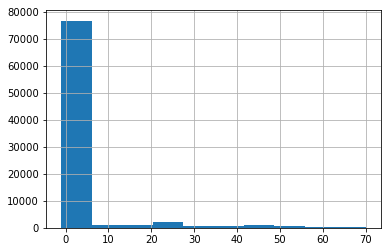

In [16]:
db_clusters_df['db_1_clusters'].hist()

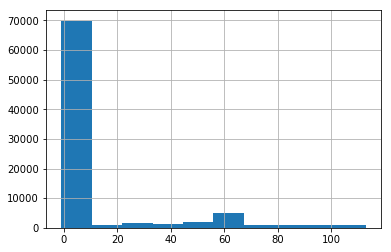

In [17]:
db_clusters_df['db_2_clusters'].hist()

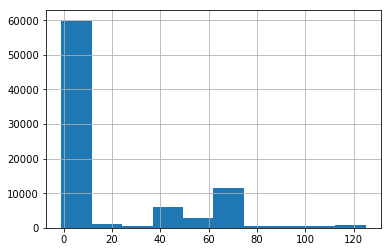

In [18]:
db_clusters_df['db_3_clusters'].hist()

### Combine DBSCAN clusters with article data

In [19]:
df2 = pd.concat([snowball_df, db_clusters_df], axis=1)

In [20]:
df2.sample(10)

,datetime,source,title,url,text_snowball,db_1_clusters,db_2_clusters,db_3_clusters
15038,2012-06-08 17:13:47,Guardian,"Spain's savings banks' culture of greed, crony...",https://www.theguardian.com/world/2012/jun/08/...,as european taxpay prepar rescu spain ail bank...,-1,-1,-1
15439,2011-08-03 08:28:23,Guardian,Switzerland moves to contain franc appreciation,https://www.theguardian.com/business/2011/aug/...,swiss author move counteract nation bank call ...,-1,-1,40
22474,2016-03-16 00:00:00,Reuters,Britain's FTSE boosted by oil stocks and house...,http://uk.reuters.com/article/britain-stocks-i...,britain oil gas stock housebuild ralli back pr...,-1,-1,-1
81348,2017-06-20 01:49:00,FT,Noble gets 120-day deadline extension from len...,https://www.ft.com/content/806ad7d4-5fc1-3d0e-...,nobl group troubl singapor list commod trader ...,-1,-1,-1
68373,2014-10-30 00:00:00,Reuters,"US STOCKS-Visa gives big boost to Dow, but GDP...",http://uk.reuters.com/article/markets-stocks-u...,us stock most edg strong read third quarter ec...,-1,-1,72
5585,2013-02-20 23:14:48,Guardian,Europe: the Right Italy,https://www.theguardian.com/commentisfree/2013...,the european econom crisi auster polici came w...,-1,-1,30
16519,2008-02-18 10:00:00,Guardian,The price isn't right,https://www.theguardian.com/commentisfree/2008...,terror global warm loom mani mind greatest thr...,-1,-1,-1
33155,2017-01-26 00:00:00,Reuters,"European shares hit 1-year high on M&A deal, A...",http://uk.reuters.com/article/europe-stocks-id...,european share climb one johnson johnson buy s...,-1,-1,-1
50905,2009-05-08,Reuters,"Nikkei hits 6-mth high in seesaw trade, Toyota",http://uk.reuters.com/article/markets-japan-st...,japan nikkei edg seesaw trade briefli touch si...,-1,-1,46
9743,2016-07-14 18:25:27,Guardian,Industrial strategy welcomed as part of govern...,https://www.theguardian.com/politics/2016/jul/...,busi leader overwhelm welcom theresa may decis...,-1,-1,-1


There's a problem with DBSCAN clusters - the majority are -1 which means they have been labelled as noise. However, it should be noted that - having looked at the clusters - the clusters it has created are very specific (Brexit, Oil prices, Bitcoin etc).

DBSCAN takes a long time to compute, so I think I will move on to K-Means.

#### Save data

In [21]:
df2.to_csv('db_clusters.csv', encoding='utf-8')

### K-Means at different values of K

Try a number of K values and check the inertia scores:

In [22]:
k_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 
            160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]
k_inertia = []
k_dict = {}

In [23]:
for k in k_values:
    km = KMeans(n_clusters=k, init='k-means++', n_jobs=-1)
    km_clusters = km.fit_predict(lsa_vecs)
    k_dict[k] = [km_clusters]
    k_inertia.append(km.inertia_)
    print('k={}, inertia={}'.format(k, km.inertia_))

k=10, inertia=64421.068638861805
k=20, inertia=59695.813133809774
k=30, inertia=56882.7491227177
k=40, inertia=54770.116928211355
k=50, inertia=53143.25191014049
k=60, inertia=51515.55860693105
k=70, inertia=50349.19539560028
k=80, inertia=49168.36768293017
k=90, inertia=48340.6163620607
k=100, inertia=47542.51199933807
k=110, inertia=46636.65028303084
k=120, inertia=45972.27045626982
k=130, inertia=45415.32951495396
k=140, inertia=44834.8483949335
k=150, inertia=44279.16152909724
k=160, inertia=43679.053118056974
k=170, inertia=43175.29117539236
k=180, inertia=42744.69665442959
k=190, inertia=42378.83807326705
k=200, inertia=41930.99289550696
k=210, inertia=41536.91324188674
k=220, inertia=41139.14698466502
k=230, inertia=40834.748349083595
k=240, inertia=40575.604307195325
k=250, inertia=40187.26234167285
k=260, inertia=39957.616646119415
k=270, inertia=39695.43858884415
k=280, inertia=39386.12816800209
k=290, inertia=39179.12043618162
k=300, inertia=38920.714925562694


#### Plot inertia at different values of k

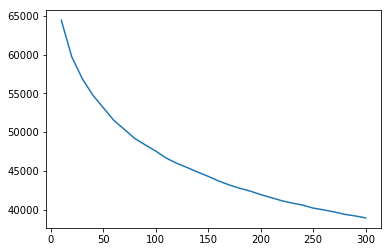

In [24]:
plt.plot(k_values, k_inertia)

The inertia score is quite a smooth line. I think around 100-150 clusters is when the gradient begins to flatten.

#### Save data

In [26]:
k_vals_inertia_list = list(zip(k_values, k_inertia))

In [27]:
np.savetxt("k_inertia.csv", k_vals_inertia_list, delimiter=",", fmt='%s')

#### Save the cluster labels for each value of k into a DataFrame

In [28]:
km_df_list = []

In [29]:
for k, clusters in k_dict.items():
    k = pd.DataFrame({k:clusters[0]})
    km_df_list.append(k)

In [30]:
km_df = pd.concat(km_df_list, axis=1)

#### Combine with article + DBSCAN clusters DataFrame

In [31]:
df3 = pd.concat([df2, km_df], axis=1)

In [32]:
df3.sample(5)

,datetime,source,title,url,text_snowball,db_1_clusters,db_2_clusters,db_3_clusters,10,20,...,210,220,230,240,250,260,270,280,290,300
23536,2008-09-12 00:00:00,Reuters,Buoyant miners help European stocks snap losin...,http://uk.reuters.com/article/markets-europe-s...,european stock end snap three session lose str...,-1,-1,-1,7,10,...,26,196,227,121,168,7,16,64,61,97
58865,2017-06-15,Reuters,SE Asia Stocks-End lower on hawkish Fed; Singa...,http://uk.reuters.com/article/southeast-asia-s...,southeast asian end hit hawkish feder reserv w...,21,56,69,8,4,...,23,30,40,10,16,39,11,62,64,53
1814,2008-08-20 08:46:30,Guardian,Bank split three ways on rates,https://www.theguardian.com/business/2008/aug/...,policymak bank england split three way second ...,-1,-1,1,1,11,...,131,28,195,155,171,35,0,251,214,130
41612,2017-04-13,Reuters,GLOBAL MARKETS-Trump comments trigger U.S. dol...,http://uk.reuters.com/article/global-markets-i...,the us dollar treasuri yield slid track bigges...,-1,-1,-1,0,2,...,76,96,162,45,194,76,59,228,259,82
4782,2010-06-14 18:40:53,Guardian,Demographic shift 'will cut UK growth',https://www.theguardian.com/business/2010/jun/...,the long term consequ effect ban immigr age so...,-1,-1,-1,1,17,...,173,193,199,13,233,82,115,262,150,203


#### Save data

In [33]:
df3.to_csv('clusters_with_kmeans.csv', encoding='utf-8')

### K-Means, k=150

Having explored the data, k=150 appeared to generate good clusters of topics. I will re-create so that this time I can capture & explore the cluster centre data.

In [34]:
km = KMeans(n_clusters=150, init='k-means++')
km.fit(lsa_vecs)
clusters = km.predict(lsa_vecs)

In [35]:
km.cluster_centers_.shape

(150, 400)

150 clusters based on the 400 latent dimensions created through LSA.

#### Explore the original dimensions

In [36]:
original_space_centroids = lsa.inverse_transform(km.cluster_centers_)
original_space_centroids.shape

(150, 157260)

In [37]:
order_centroids = original_space_centroids.argsort()[:, ::-1]
order_centroids.shape

(150, 157260)

#### Save data

In [38]:
np.save('ordered_centroids', order_centroids)

#### Examine top 10 TF-IDF features  in each cluster

In [39]:
for cluster in range(150):
    features = order_centroids[cluster,0:10]
    print('Cluster {}\n'.format(cluster))
    for feature in features:
        print(feature_names[feature])
    print('\n')

Cluster 0

spreadbett
financi spreadbett
seen
expect britain ftse
expect britain
spreadbett expect
financi spreadbett expect
britain ftse germani dax
britain ftse germani
spreadbett expect britain


Cluster 1

economi
debt
growth
govern
econom
rate
bank
polici
crisi
recess


Cluster 2

nikkei
yen
corp
japan
japanes
euro
trade
nikkei futur
billion yen
gold


Cluster 3

nasdaq
high low
low
dow
issu
high
rate
fed
advanc
et


Cluster 4

russia
russian
ukrain
sanction
putin
moscow
roubl
compani
oil
tension


Cluster 5

mc
santand
san mc
santand san mc
santand san
banco
european
san
banco santand
banco santand san


Cluster 6

nikkei
yen
corp
motor
japan
jpx
jpx nikkei
jpx nikkei index
nikkei index
toyota


Cluster 7

greec
greek
athen
tsipra
debt
bailout
eurozon
countri
minist
auster


Cluster 8

european
stoxx
share
bank
stock
pan european
pan
sector
europ
european share


Cluster 9

ft
trump
video
nyt
presid
firstft
mr
donald
brexit
donald trump


Cluster 10

earn releas
releas
earn
year


### Move data to DataFrame

In [40]:
km_150 = pd.DataFrame({'original_km_150':k_dict[150][0], 'new_km_150':clusters})

In [41]:
km_150.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84155 entries, 0 to 84154
Data columns (total 2 columns):
new_km_150         84155 non-null int32
original_km_150    84155 non-null int32
dtypes: int32(2)
memory usage: 657.5 KB


In [42]:
km_150.sample(5)

,new_km_150,original_km_150
32985,146,33
42236,58,73
73447,147,140
38327,110,65
5859,90,2


### Combine with original article data

In [43]:
df_km_150 = pd.concat([snowball_df, km_150], axis=1)

In [44]:
df_km_150.head(5)

,datetime,source,title,url,text_snowball,new_km_150,original_km_150
0,2008-05-23 23:01:00,Guardian,$135 and rising ... has cheap oil gone for ever?,https://www.theguardian.com/business/2008/may/...,fresh maul byelect gordon brown met two leader...,105,23
1,2007-08-15 15:41:12,Guardian,$2 pound sails into the sunset,https://www.theguardian.com/business/2007/aug/...,take kid florida next week yet collect dollar ...,139,0
2,2010-12-20 17:58:56,Guardian,$2tn debt crisis threatens to bring down 100 U...,https://www.theguardian.com/business/2010/dec/...,more american citi could go bust next debt cri...,92,62
3,2005-01-28 15:07:10,Guardian,'A dream deal',https://www.theguardian.com/business/2005/jan/...,look around hous bound good made procter gambl...,23,101
4,2016-12-06 18:28:50,Guardian,'A landscape of exhaustion and moral decay' – ...,https://www.theguardian.com/business/2016/dec/...,when mark carney insist speech liverpool john ...,131,129


### Save data

In [45]:
df_km_150.to_csv('km.csv', encoding='utf-8')

In [46]:
df_km_150.to_pickle('km.pkl')

In [47]:
km_150.to_csv('km_150_clusters.csv', encoding='utf-8')
km_150.to_pickle('km_150_clusters.pkl')